In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
# !pip install tensorboardX
# from tensorboardX import SummaryWriter
from datetime import datetime


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validationงว ามา
training_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

# Class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 170498071/170498071 [00:02<00:00, 65621290.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


cat  dog  truck  dog


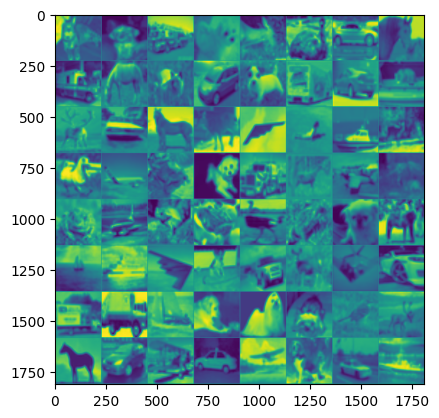

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [3]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [ ]:
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

#---Variable initialization---
torch.manual_seed(42)
#vvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
#vvvvvvv Add this term vvvvvvvv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#-----------------------------

# PyTorch models inherit from torch.nn.Module
#---CNN---
class DeepModelT4(nn.Module):
    def __init__(self):
        super(DeepModelT4, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, 3, stride=2, padding=1)
        self.conv6 = nn.Conv2d(256, 512, 3, padding=1)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv3(self.conv2(self.conv1(x)))))
        x = self.pool(F.relu(self.conv6(self.conv5(self.conv4(x)))))
        x = x.view(-1, 512 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Model init
model = DeepModelT4().to(device)
summary(model, (3, 224, 224))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizers specified in the torch.optim package
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, mverbose=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-4)

early_stopping = EarlyStopping(patience=5, min_delta=0.01)

# Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 100
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

t_0_accelerated = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    # scheduler.step(valid_loss)

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_model.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (T4): {t_end_accelerated} sec")
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

#---Variable initialization---
torch.manual_seed(42)
#vvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
#vvvvvvv Add this term vvvvvvvv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#-----------------------------

# PyTorch models inherit from torch.nn.Module
#---CNN---
class DeepModelT4(nn.Module):
    def __init__(self):
        super(DeepModelT4, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, 3, stride=2, padding=1)
        self.conv6 = nn.Conv2d(256, 512, 3, padding=1)
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv3(self.conv2(self.conv1(x)))))
        x = self.pool(F.relu(self.conv6(self.conv5(self.conv4(x)))))
        x = x.view(-1, 512 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Model init
model = DeepModelT4().to(device)
summary(model, (3, 224, 224))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizers specified in the torch.optim package
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, mverbose=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-4)

early_stopping = EarlyStopping(patience=5, min_delta=0.01)

# Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 100
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

t_0_accelerated = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    # scheduler.step(valid_loss)

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_model.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (T4): {t_end_accelerated} sec")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
            Conv2d-2         [-1, 64, 224, 224]          18,496
            Conv2d-3        [-1, 128, 112, 112]          73,856
         MaxPool2d-4          [-1, 128, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]         295,168
            Conv2d-6          [-1, 256, 28, 28]         590,080
            Conv2d-7          [-1, 512, 28, 28]       1,180,160
         MaxPool2d-8          [-1, 512, 14, 14]               0
            Linear-9                 [-1, 1024]     102,761,472
          Dropout-10                 [-1, 1024]               0
           Linear-11                  [-1, 512]         524,800
           Linear-12                  [-1, 256]         131,328
           Linear-13                   [-1, 10]           2,570
Total params: 105,578,826
Trainable par

In [ ]:
plot_graph(training_logs)

In [ ]:
# Inference phase
PATH = './cp/best_model.pth'
loaded_model = DeepModelT4()
loaded_model.load_state_dict(torch.load(PATH))
acc_test = 0
test_loss = 0
loaded_model.to(device).eval()
stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32).to(device)
# for i, tdata in enumerate(validation_loader):
#     tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
#     toutputs = loaded_model(tinputs)
#     loss = loss_fn(toutputs, tlabels)
#     test_loss += loss
#     # Argmax one-hot pred to class vector
#     _, preds_t = torch.max(toutputs, 1)
#     acc_test += (preds_t == tlabels).float().mean().item()
#     # Store vec
#     stored_lbs = torch.cat((stored_lbs, tlabels), 0)
#     stored_preds = torch.cat((stored_preds, preds_t), 0)

from torch.cuda.amp import autocast

with torch.no_grad():
    for i, tdata in enumerate(validation_loader):
        tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
        with autocast():
            toutputs = loaded_model(tinputs)
        loss = loss_fn(toutputs, tlabels)
        test_loss += loss
        _, preds_t = torch.max(toutputs, 1)
        acc_test += (preds_t == tlabels).float().mean().item()
        stored_lbs = torch.cat((stored_lbs, tlabels), 0)
        stored_preds = torch.cat((stored_preds, preds_t), 0)


accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

In [ ]:
# @title ##### confusion matrix function
# https://github.com/fyse-nassar/Malware-Family-Classification/blob/master/Malware%20Opcode%20Ngrams%20Generator.ipynb
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    Normalization can be applied by setting `normalize=True`.
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)    #office-31
    plt.xticks(tick_marks, classes, rotation=20, fontsize=12)    #office-home
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize==True:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+1)
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    # print(cm)

    formated = '.2f' if normalize==True else 'd'
    #---manual---
    thresh = cm.max() / 2.
    #thresh > 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], formated),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #---sns---
    #df_cm = pd.DataFrame(cm, classes, classes)
    #sns.heatmap(df_cm, annot=True, fmt=formated, cmap=cmap)

    plt.gcf().set_size_inches(8, 6)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.margins(2,2)
    plt.tight_layout()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, normalized_mutual_info_score, adjusted_rand_score#, f1_score
# Class labels
pos_labels = np.arange(10)
lb_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

lb = stored_lbs.cpu()
prd = stored_preds.cpu()
#---confusion matrix
cm_target = confusion_matrix(y_true=lb,
                            y_pred=prd,
                            labels=pos_labels,
                            normalize='true',
                            )
plt.figure()
plt.rcParams.update({'font.size': 10, 'figure.figsize': (2,2)})
plot_confusion_matrix(cm_target,
                        classes=lb_classes,
                        normalize=True,
                        title='Conf. Mat. w.r.t. CIFAR-10 ds',
                        cmap=plt.cm.binary #Blues_r
                        )    #Blues_r = off-white diagonal
#---F1-score/Precision/Recall scores
print("Precision/Recall/F-beta score:", precision_recall_fscore_support(lb, prd, average='weighted', zero_division=0,
                                          beta=1.0)) #labels=label_classes))
#---Normalized Mutual Information (NMI) score
nmi_score = normalized_mutual_info_score(labels_true=lb,
                                        labels_pred=prd,
                                        average_method='arithmetic',
                                        )
#---Rand Index (RI) score
ri_score = adjusted_rand_score(labels_true=lb,
                                labels_pred=prd,
                                )
print(f"NMI score: {nmi_score}, RI score: {ri_score}")